In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix
import time

# Reading the datasets

In [2]:
x_train = pd.read_excel('Dataset/data.xlsx', sheet_name ='azip', header=None)
y_train = pd.read_excel('Dataset/data.xlsx', sheet_name ='dzip', header=None)
x_test = pd.read_excel('Dataset/data.xlsx', sheet_name ='testzip', header=None).T.values
y_test = pd.read_excel('Dataset/data.xlsx', sheet_name ='dtest', header=None).T.values

# Merge training data into the training set

In [3]:
train=pd.concat([x_train,y_train],axis=0).T.values

# Print the first 160

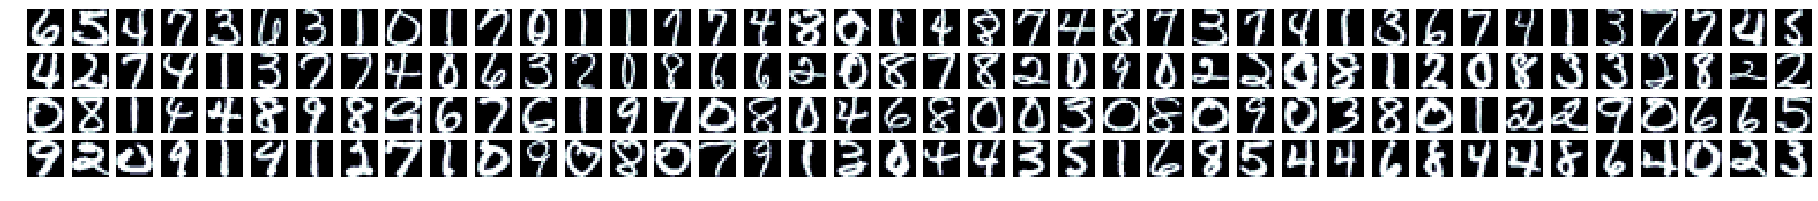

In [4]:
plt.figure(figsize=(32, 32))
for i, row in enumerate(train[:160,:-1]):
    plt.subplot(40,40,i+1)
    plt.imshow(row.reshape(16,16),cmap='bone')
    plt.axis('off')

# The formula from the book for calculating residuals per basis vector set

In [5]:
basis={}
for i in range(0,10):
    basis[i]=svds(train[train[:,-1]==i][:,:-1].T,10)[0]

In [6]:
def relative_residual(x_test):
    res=np.zeros((10,2))
    for i in range(0,10):
        res[i]=[np.linalg.norm(((np.eye(basis[i].T.shape[1])-(basis[i]@basis[i].T))@x_test))/np.linalg.norm(x_test),i]
    return res[np.argmin(res[:,0]),1]

# The first experiment is for basis = 10

In [7]:
y_pred=np.apply_along_axis(relative_residual, 1, x_test)

In [8]:
accuracy_score(y_test, y_pred.squeeze())

0.931738913801694

# Computing the experiment for basis vectors between 5-20 and storing the results as well as printing the total time it takes

In [52]:
stime=time.time()

comps_to_res=[]
comps_per_basis_per_num=[]
for comps in range(5,21):
    basis={}
    for i in range(0,10):
        basis[i]=svds(train[train[:,-1]==i][:,:-1].T,comps)[0]
        
    y_pred=np.apply_along_axis(relative_residual, 1, x_test)
    
    cm = confusion_matrix(y_test, y_pred.squeeze())
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    comps_per_basis_per_num.append([comps,cm.diagonal()])
    comps_to_res.append([comps,np.round(accuracy_score(y_test, y_pred.squeeze()),4)])
    
print('Duration: ', time.time()-stime)

Duration:  187.477548122406


# The total accuracy score for all classes

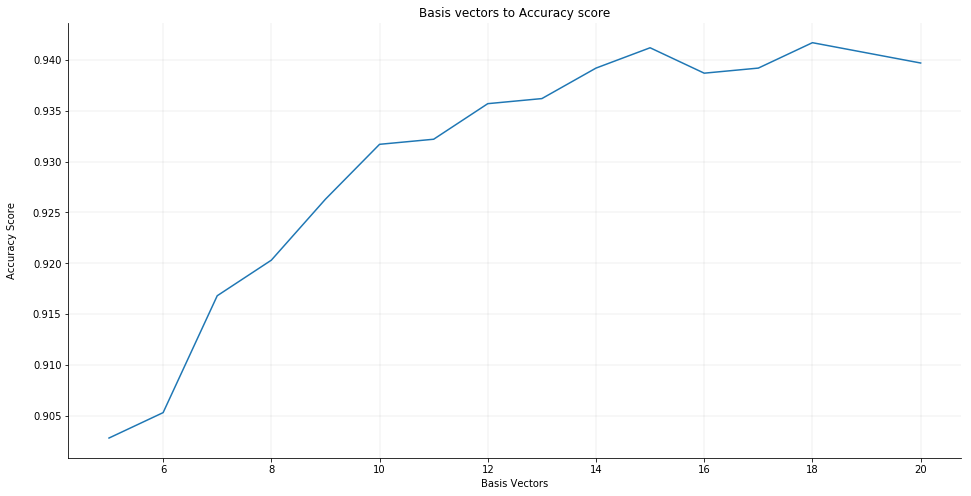

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pd.DataFrame(comps_to_res)[0], pd.DataFrame(comps_to_res)[1], label=('Basis vectors to Accuracy score'))
ax.set_ylabel('Accuracy Score\n')
ax.set_xlabel('Basis Vectors')
ax.set_title('Basis vectors to Accuracy score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# We can observe that numbers 0 and 1 are easily detectable even for basis=5

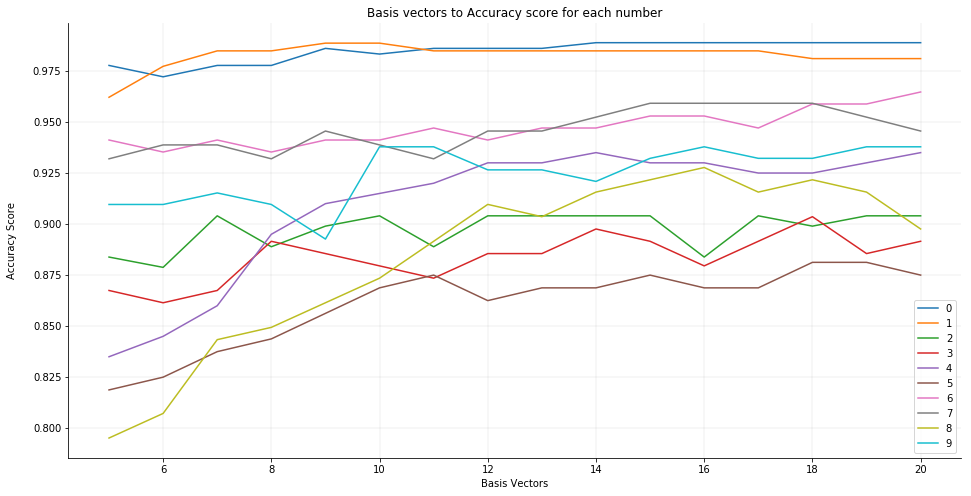

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(0,10):
    ax.plot(pd.DataFrame(comps_per_basis_per_num)[0], pd.DataFrame(comps_per_basis_per_num)[1].map(lambda x: x[i]), label=('{}'.format(i)))
    ax.set_ylabel('Accuracy Score\n')
    ax.set_xlabel('Basis Vectors')
    ax.legend()
    ax.set_title('Basis vectors to Accuracy score for each number')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Indeed the misclassified numbers are in most cases very badly written

In [12]:
misclassified=x_test[np.where(y_pred != y_test.squeeze())]

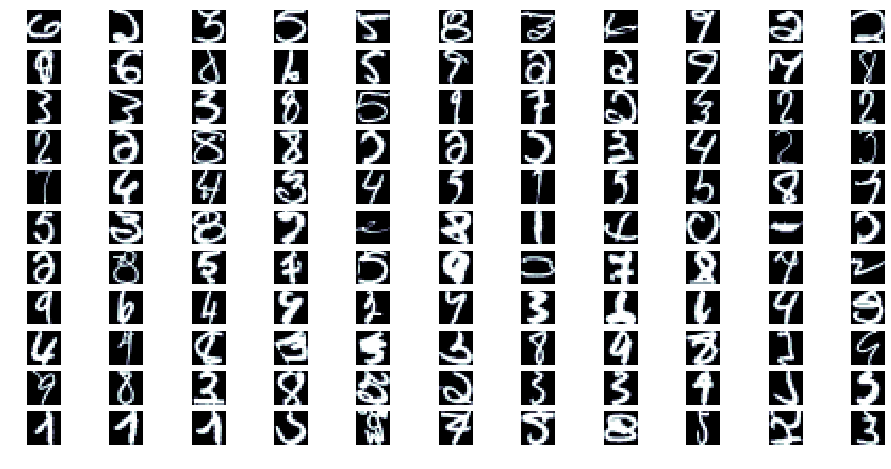

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
for i, row in enumerate(misclassified):
    plt.subplot(11,11,i+1)
    plt.imshow(row.reshape(16,16),cmap='bone')
    plt.axis('off')

# Again running the experiment while keeping the first two vectors always with a basis of 5

In [51]:
stime = time.time()

comps_to_res=[]
comps_per_basis_per_num=[]
for comps in range(5,21):
    basis={}
    for i in range(2,10):
        basis[i]=svds(train[train[:,-1]==i][:,:-1].T,comps)[0]
        
    basis[0]=svds(train[train[:,-1]==0][:,:-1].T,5)[0]
    basis[1]=svds(train[train[:,-1]==1][:,:-1].T,5)[0]
    y_pred=np.apply_along_axis(relative_residual, 1, x_test)
    
    cm = confusion_matrix(y_test, y_pred.squeeze())
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    comps_per_basis_per_num.append([comps,cm.diagonal()])
    comps_to_res.append([comps,np.round(accuracy_score(y_test, y_pred.squeeze()),4)])
    
print('Duration: ', time.time()-stime)

Duration:  185.59358739852905


# The total accuracy has dropped

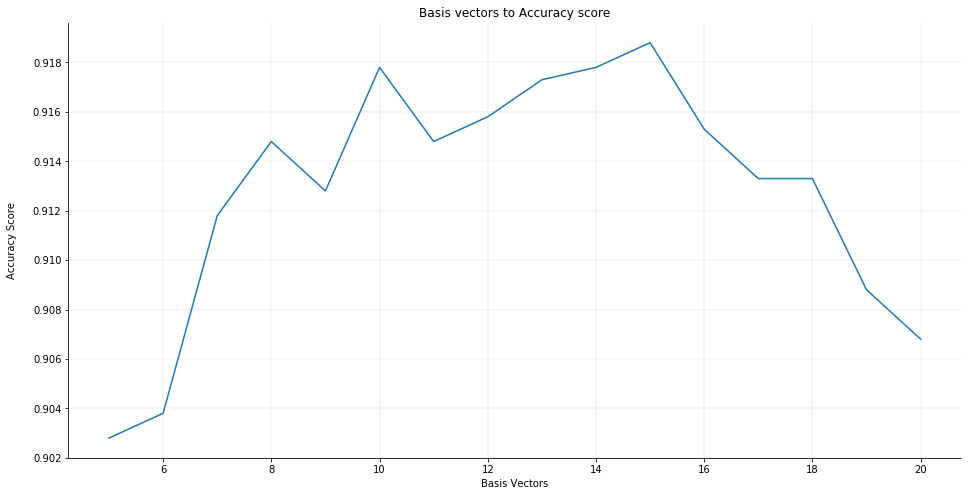

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pd.DataFrame(comps_to_res)[0], pd.DataFrame(comps_to_res)[1], label=('Basis vectors to Accuracy score'))
ax.set_ylabel('Accuracy Score\n')
ax.set_xlabel('Basis Vectors')
ax.set_title('Basis vectors to Accuracy score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Two stage algorithm with SVD

In [54]:
comps_to_res=[]
comps_per_basis_per_num=[]

for i in range(0,10):
    basis[i]=svds(train[train[:,-1]==i][:,:-1].T,1)[0]
    
y_pred=np.apply_along_axis(relative_residual, 1, x_test)

cm = confusion_matrix(y_test, y_pred.squeeze())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

comps_per_basis_per_num.append([comps,cm.diagonal()])
comps_to_res.append([comps,np.round(accuracy_score(y_test, y_pred.squeeze()),4)])

alr_classified=np.where(comps_per_basis_per_num[0][1] > (comps_per_basis_per_num[0][1].mean() + 2*comps_per_basis_per_num[0][1].std()))

print("Classes with a residual of 2 standard deviations above the mean: ", alr_classified[0])

Classes with a residual of 2 standard deviations above the mean:  [1]


In [59]:
stime = time.time()

comps_to_res=[]
comps_per_basis_per_num=[]
for comps in range(5,21):
    basis={}
    basis[1]=svds(train[train[:,-1]==1][:,:-1].T,1)[0]
    for i in range(0,10):
        if(i not in alr_classified):
            basis[i]=svds(train[train[:,-1]==i][:,:-1].T,comps)[0]

    y_pred=np.apply_along_axis(relative_residual, 1, x_test)

    cm = confusion_matrix(y_test, y_pred.squeeze())
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    comps_per_basis_per_num.append([comps,cm.diagonal()])
    comps_to_res.append([comps,np.round(accuracy_score(y_test, y_pred.squeeze()),4)])
    
print('Duration: ', time.time()-stime)

Duration:  63.31361436843872


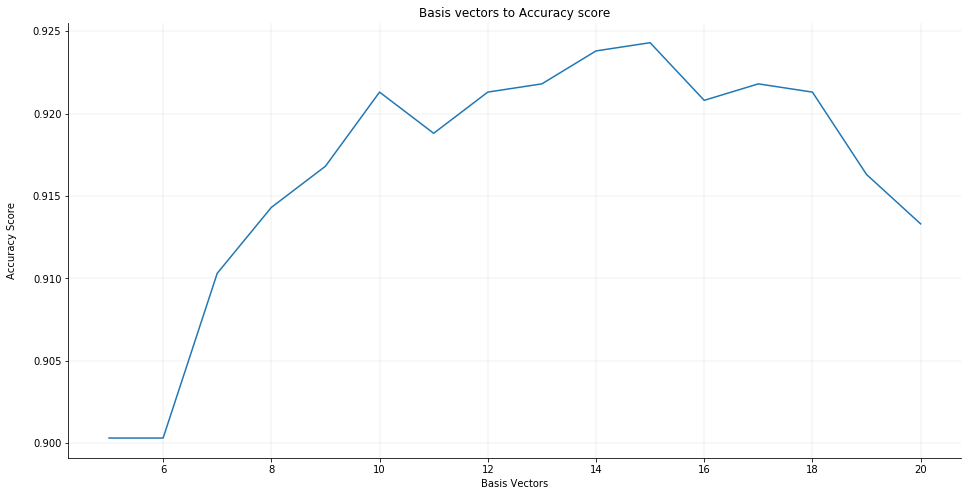

In [60]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pd.DataFrame(comps_to_res)[0], pd.DataFrame(comps_to_res)[1], label=('Basis vectors to Accuracy score'))
ax.set_ylabel('Accuracy Score\n')
ax.set_xlabel('Basis Vectors')
ax.set_title('Basis vectors to Accuracy score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Tangent Distance

In [208]:
from scipy.misc import imresize
from scipy.ndimage import rotate
import warnings
warnings.filterwarnings('ignore')

def transform_img(img):
    train_point=img.reshape(16,16)
    train_point=np.roll(train_point,1)
    train_point=np.roll(train_point,-1, axis=0)
    train_point=imresize(train_point, (20,20))
    train_point=rotate(train_point,5)
    return train_point.reshape(-1,1).flatten()

In [209]:
x_train2=x_train.T.values
x_train2=np.apply_along_axis(lambda x: transform_img(x), 1, x_train2)

In [210]:
x_test2=x_test
x_test2=np.apply_along_axis(lambda x: transform_img(x), 1, x_test2)

In [214]:
from sklearn.neighbors import KNeighborsClassifier

In [232]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(x_train2, y_train.T.values)
y_pred=clf.predict(x_test2)

In [233]:
accuracy_score(y_test.flatten(), y_pred)

0.9123069257598405